# 第13章 平稳时间序列

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
import seaborn as sns

data = pd.read_stata('../2_Data/Data-2e/gdp_china.dta')
data.set_index('year', inplace=True)
data['lny'] = np.log(data['y'])
data['dlny']  = data['lny'].diff()
data['dy'] = (data['y'] - data['y'].shift(1))/data['y'].shift(1)

## 13.1 时间序列的自相关

定义  k阶自协方差
autocovanriance of oder k
$$\gamma_k\equiv Cov(y_t,y_{t-k})=E[(y_t-\mu)(y_{t-K}-\mu)]$$
- $\mu$ 为总体均值（$E(y)$）
- 反映了同一变量相隔k期之间的自相关程度
- $k=0$ 时，$\gamma_0=Var(y)$
- 估计值为样本自协方差：$$\hat\gamma_k \equiv = \frac{1}{T-k}\sum_{t=1}^{T-k}(y_t-\overline y)(y_{t+k}-\overline y)$$

定义 k阶自相关系数
autocorrelation of oder k
$$\rho_k \equiv \frac{Cov(y_t,y_{t+k})}{Var(y_t)}$$
- 自相关系数是自协方差的标准化，取值范围[-1,1]
- 估计值为 $$\hat\rho_k \equiv \frac{\hat\gamma_k}{\hat\gamma_0}$$
	- 其中$\hat\rho_0 \equiv \frac{1}{T-1}\sum_{i=1}^T (y_t-\overline y)^2$ 为样本方差

$\rho_k$ 不依赖于具体时间，仅是滞后阶数k的函数，称为<span style="color:#00b0f0">自相关函数（Auto-correlation function，ACF）</span>

（k，$\rho_k$）画出图，称为<span style="color:#00b0f0">自相关图（correlogram）</span>


<Axes: xlabel='year', ylabel='y'>

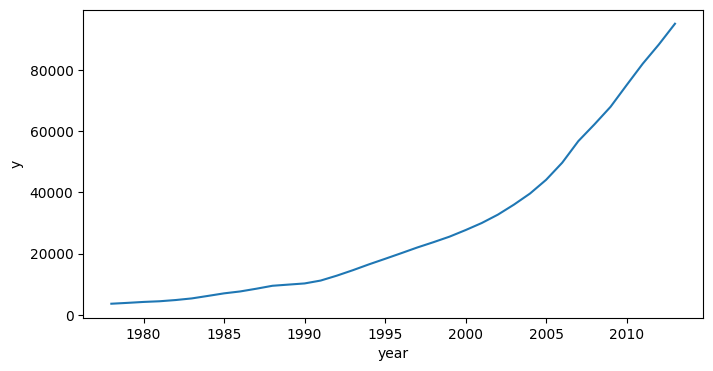

In [2]:
# 时间序列的趋势图
fig = plt.figure(figsize=(8,4))
sns.lineplot(x='year', y='y', data=data)

<Axes: xlabel='year', ylabel='lny'>

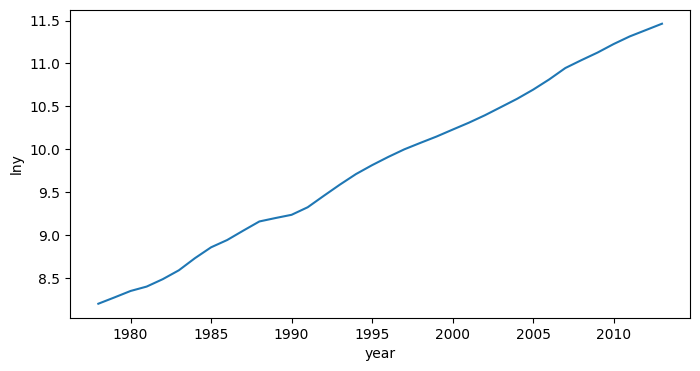

In [3]:
# 对数时间序列的趋势图
fig = plt.figure(figsize=(8,4))
sns.lineplot(x='year', y='lny', data=data)

<Axes: xlabel='year', ylabel='dlny'>

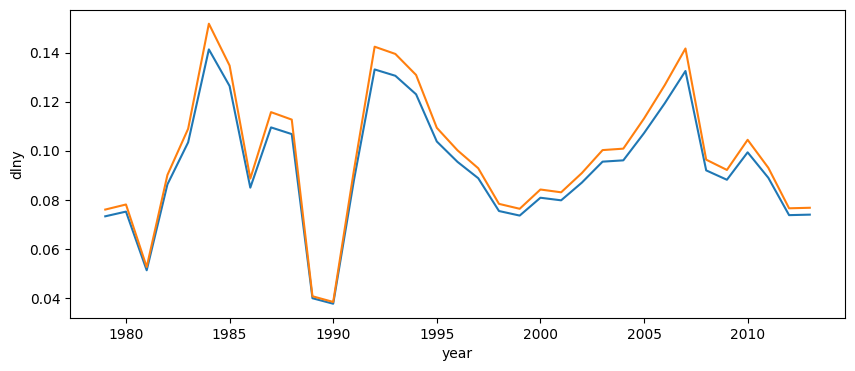

In [4]:
# 对比
fig = plt.figure(figsize=(10,4))
sns.lineplot(x='year', y='dlny', data=data)
sns.lineplot(x='year', y='dy', data=data)

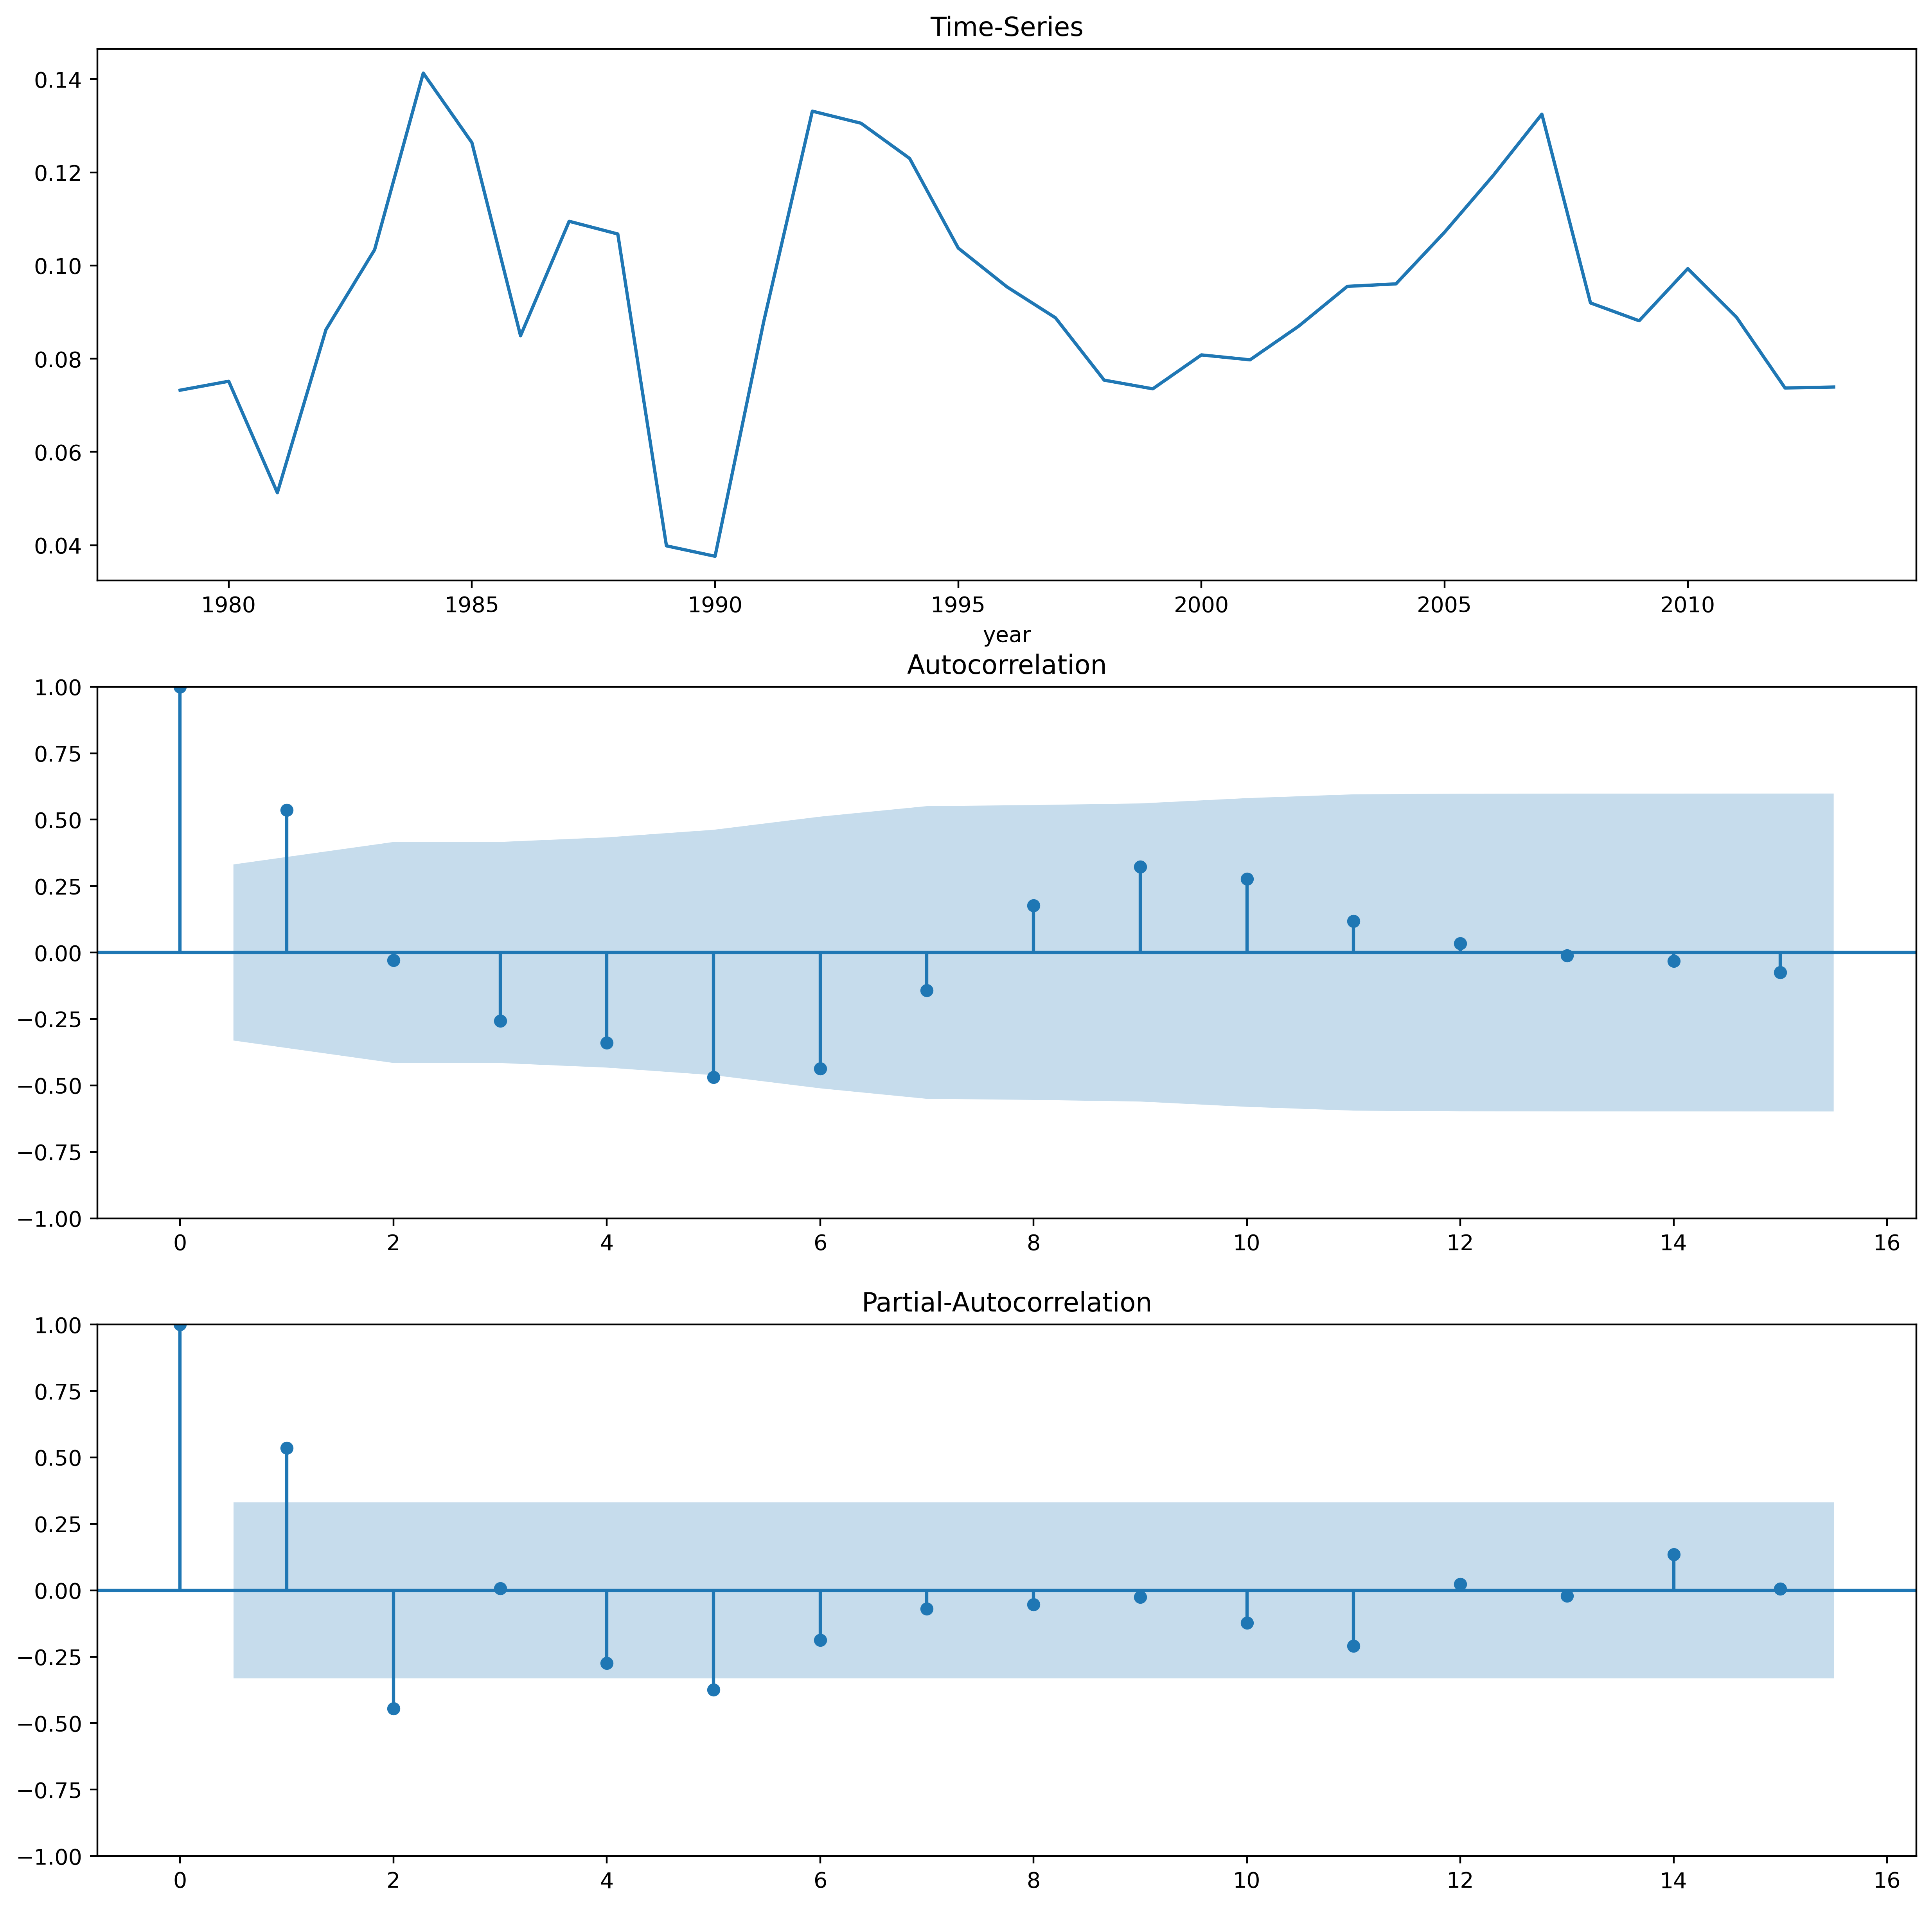

,Lags,ACF,PACF,Q,Prob(Q)
0,1,0.536006,0.551770,10.942826,9.396672e-04
1,2,-0.029844,-0.483220,10.977778,4.132432e-03
2,3,-0.257885,0.019638,13.669137,3.391922e-03
3,4,-0.340541,-0.333263,18.513620,9.791083e-04
4,5,-0.468739,-0.465579,27.998054,3.643067e-05
5,6,-0.437134,-0.281811,36.531051,2.173118e-06
6,7,-0.142519,-0.163810,37.470463,3.819809e-06
7,8,0.177405,-0.141457,38.979982,4.957594e-06
8,9,0.321968,-0.081307,44.143216,1.328198e-06
9,10,0.276829,-0.245950,48.112867,5.919004e-07


In [5]:
from cq import acfgram
data = data.dropna()

ac = acfgram(data['dlny'],lags=15)
ac

## 13.2 一阶自回归

用过去值来预测当前值，一阶自回归（AR(1)）
$$y_t = \beta_0+\beta_1 y_{t-1}+\epsilon_t \qquad (t=2,\cdots,n) \tag{13.6}$$
- 扰动项 $\epsilon_t$ 为白噪声
- 扰动项 $\epsilon_t$ 无自相关，意味着任意不同期的扰动项协方差为0，是球形扰动项
- OLS估计是一致的，但损失第一个数据
- 可使用MLE，但需加速扰动项服从正态分布

In [6]:
# 使用OLS回归
data2012 = data[data.index<2013].dropna()
mod_ols = sm.OLS(endog=data2012['dlny'], 
             exog=sm.add_constant(data2012['dlny'].shift(1)),
             missing='drop') # 缺失值直接drop
res_ols = mod_ols.fit(cov_type='HC1', use_t=True)
print(res_ols.summary())

                            OLS Regression Results                            
Dep. Variable:                   dlny   R-squared:                       0.288
Model:                            OLS   Adj. R-squared:                  0.265
Method:                 Least Squares   F-statistic:                     12.99
Date:                Sun, 05 May 2024   Prob (F-statistic):            0.00108
Time:                        22:55:12   Log-Likelihood:                 80.961
No. Observations:                  33   AIC:                            -157.9
Df Residuals:                      31   BIC:                            -154.9
Df Model:                           1                                         
Covariance Type:                  HC1                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0438      0.014      3.039      0.0

In [7]:
# 使用MLE
from statsmodels.tsa.ar_model import AutoReg
mod_mle = AutoReg(data2012['dlny'], lags=1)
res_mle = mod_mle.fit(cov_type='HC1',use_t=True)
print(res_mle.summary())

                            AutoReg Model Results                             
Dep. Variable:                   dlny   No. Observations:                   34
Model:                     AutoReg(1)   Log Likelihood                  80.961
Method:               Conditional MLE   S.D. of innovations              0.021
Date:                Sun, 05 May 2024   AIC                           -155.922
Time:                        22:55:12   BIC                           -151.433
Sample:                             1   HQIC                          -154.412
                                   34                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0438      0.014      3.039      0.005       0.014       0.073
dlny.L1        0.5363      0.149      3.604      0.001       0.233       0.840
                                    Roots           

e:\Eco-stats\eco-stats\.venv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


In [8]:
from math import exp
# 预测值
a = res_ols.predict([1,data.loc[2013,'dlny']])
# OLS模型回归后的预测：
## - 参数是对应的 const + 其他自变量的值
b = res_mle.predict(len(data['lny']),len(data['lny']))
# AutoReg模型回归后的预测：
## - 参数是start, end

resid = exp(a + data.loc[2012,'lny']) - data.loc[2013,'y']
resid

e:\Eco-stats\eco-stats\.venv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
e:\Eco-stats\eco-stats\.venv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
e:\Eco-stats\eco-stats\.venv\lib\site-packages\statsmodels\tsa\deterministic.py:308: UserWarning: Only PeriodIndexes, DatetimeIndexes with a frequency set, RangesIndexes, and Index with a unit increment support extending. The index is set will contain the position relative to the data length.
  fcast_index = self._extend_index(index, steps, forecast_index)
C:\Users\NINGMEI\AppData\Local\Temp\ipykernel_62784\669965748.py:10: DeprecationWarning: Conversion of an array with ndim > 0 to

906.3107431212557

## 13.3 高阶自回归

高阶自回归（AR(p)）:
$$y_t = \beta_0+\beta_1 y_{t-1}+\cdots+\beta_p y_{t-p}+\epsilon_t  \tag{13.6}$$
但通常我们并不知道p是多少，需要估计出p是多少。有三个方法：
1. 由大到小的序贯t规则：
	- 设一个最大滞后值，看最大滞后期的系数是否显著，不显著就往小了进行估计，直至显著。
2. 使用信息准则：
	- 使AIC和BIC最小的p，AIC在大样本中会高估，取两者滞后阶数的大者
3. 检验模型残差的自相关性(Q检验)，如存在，继续扩大。

In [13]:
from cq import estimate_p

data = data[data.index< 2013]
df = estimate_p(data, 'dlny', 6)
df

e:\Eco-stats\eco-stats\Econometrics_CQ\1_Code\cq.py:214: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  return res.params.index[-1], res.nobs, res.pvalues[-1], res.aic, res.bic
e:\Eco-stats\eco-stats\Econometrics_CQ\1_Code\cq.py:214: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  return res.params.index[-1], res.nobs, res.pvalues[-1], res.aic, res.bic
e:\Eco-stats\eco-stats\Econometrics_CQ\1_Code\cq.py:214: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use

index,nobs,p-value,AIC,BIC
dlny_l1,33.0,0.000313,-157.9223[min],-154.9293[min]
dlny_l2,32.0,0.00336,-157.398728,-153.00152
dlny_l3,31.0,0.90479[>0.05],-153.816216,-148.080267
dlny_l4,30.0,0.12324[>0.05],-150.839698,-143.833711
dlny_l5,29.0,0.031682,-148.910347,-140.706572
dlny_l6,28.0,0.07992[>0.05],-149.345486,-140.020054


In [19]:
from statsmodels.tsa.ar_model import ar_select_order

mod = ar_select_order(data['dlny'], maxlag=6
                      ,ic='bic',glob=True)
print(mod.ar_lags)

[1, 2, 5]


e:\Eco-stats\eco-stats\.venv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
e:\Eco-stats\eco-stats\.venv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


## 13.4 自回归分布滞后模型

### autoregressive distributed lag model

在自回归模型中，引入其他解释变量，$ARDL(p,q)$
$$y_t = \beta_0 +\beta_1 y_{t-1}+\cdots+\beta_p y_{t-p}+\gamma_1 x_{t-1}+\cdots+\gamma_q x_{t-q}+\epsilon_t \tag{13.11}$$
- p为y的滞后阶数
- q为x的滞后阶数
- 还可引入更多的解释变量，如z的r阶滞后

对于（p,q）的选择，可使用：
- 信息准则
- 序贯检验

### 长期效应 or 长期乘数
- 因y和x均为平稳序列，各滞后期序列的均值均为 $y^*$ 和 $x^*$。对（13.11）两边同时求期望，整理后可得：
- $$\frac{dy^*}{dx^*}=\frac{\gamma_1+\cdots+\gamma_q}{1-\beta_1-\cdots-\beta_p}$$


In [28]:
from statsmodels.tsa.ardl.model import ARDL

data_ = pd.read_stata('../2_Data/Data-2e/border.dta')
endog = data_['border']

exog = data_[['drought','diff','age','rival','wall','unified']]
exog_lags = {
             'drought':[1],
             'diff':0,
             'age':0,
             'rival':0,
             'wall':0,
             'unified':0
             }
mod_ardl = ARDL(endog,2, exog, exog_lags)
res_ardl = mod_ardl.fit()
print(res_ardl.summary())

                                  ARDL Model Results                                 
Dep. Variable:                        border   No. Observations:                  213
Model:             ARDL(2, 1, 0, 0, 0, 0, 0)   Log Likelihood                -312.766
Method:                      Conditional MLE   S.D. of innovations              1.065
Date:                       Mon, 06 May 2024   AIC                            645.532
Time:                               00:56:37   BIC                            679.050
Sample:                                    2   HQIC                           659.081
                                         213                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.8190      0.412      1.988      0.048       0.007       1.631
border.L1      1.5183      0.054     27.951      0.000       1.411       1.

In [31]:
# drought的长期乘数
res_ardl.params
lrm_drought  = res_ardl.params['drought.L1']/(1-res_ardl.params['border.L1']-res_ardl.params['border.L2'])
lrm_drought 

-15.671094018656975

## 13.5 误差修正模型

## 13.6 移动平均与ARMA模型

## 13.7 脉冲响应函数

## 13.8 向量自回归过程

## 13.9 VAR的脉冲响应函数

## 13.10 格兰杰因果检验

## 13.11 VAR的Stata命令及实例

## 13.12 时间趋势项

## 13.13 季节调整

## 13.14 日期数据的导入